In [1]:
import os

In [19]:
## Only required if running on Docker GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.chdir("/tf/notebooks")
!pip3 install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import Model, callbacks
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Flatten, Dense, Dropout, Layer, Input
from keras import metrics, optimizers

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.12.0
Num GPUs Available:  1


In [21]:
from utils import load_data

BATCH_SIZE = 32
train_dataset = load_data(batch_size=BATCH_SIZE)

Found 6194 files belonging to 1 classes.
Found 6194 files belonging to 1 classes.
Found 6194 files belonging to 1 classes.


In [23]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

2023-04-27 09:05:34.785497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype string and shape [6194]
	 [[{{node Placeholder/_9}}]]
2023-04-27 09:05:34.785788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype string and shape [6194]
	 [[{{node Placeholder/_9}}]]


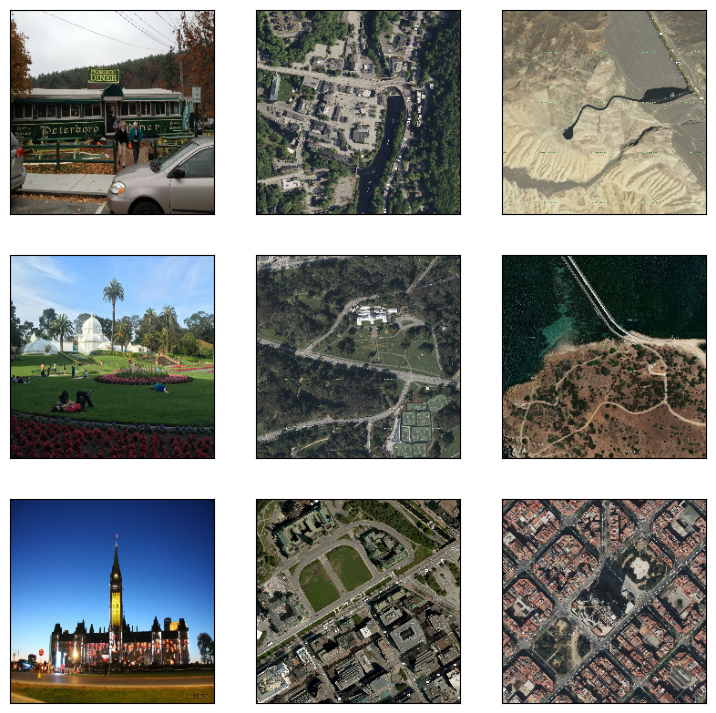

In [24]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [11]:
def init_embedding_model(name: str) -> Model:
    vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

    # Freeze layers for training
    for layer in vgg16.layers:
        layer.trainable = False


    # Create a new 'top' of the model of fully-connected layers for Places365
    top_model = vgg16.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu', name="fc1")(top_model)
    top_model = Dropout(0.5, name="drop_fc1")(top_model)
    top_model = Dense(512, activation='relu', name="fc2")(top_model)
    top_model = Dropout(0.2, name="drop_fc2")(top_model)
    output_layer = Dense(256, activation='softmax', name="predictions")(top_model)

    embedding_model = Model(inputs=vgg16.input,
                  outputs=output_layer,
                  name=name)

    return embedding_model


In [12]:
class DistanceLayer(Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    source: https://keras.io/examples/vision/siamese_network/
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance


In [13]:
def init_network_model(batch_size, input_shape=(224, 224, 3)) -> Model:

    anchor_input = Input(name="anchor",
                         batch_size=batch_size,
                         shape=input_shape)

    positive_input = Input(name="positive",
                           batch_size=batch_size,
                           shape=input_shape)

    negative_input = Input(name="negative",
                           batch_size=batch_size,
                           shape=input_shape)

    sat_model = init_embedding_model("satellite")
    ter_model = init_embedding_model("terrestrial")

    distances = DistanceLayer()(
        sat_model(preprocess_input(anchor_input)),
        ter_model(preprocess_input(positive_input)),
        ter_model(preprocess_input(negative_input)),
    )

    return Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=distances
    )

In [14]:
class SiameseNetwork(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    Siamese Network.
    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)

    source: https://keras.io/examples/vision/siamese_network/
    """

    def __init__(self, siamese_model, margin=0.5):
        super().__init__()
        self.siamese_model = siamese_model
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")


    def call(self, inputs):
        return self.siamese_model(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_model.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_model.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_model(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [32]:
# Checkpoint during training
checkpoint_path = "siamese_chkpts/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        save_weights_only=False,
                                        save_freq=10,
                                        verbose=1)

In [33]:
siamese_model = init_network_model(BATCH_SIZE)  # Set weights path to `None` to load randomised top with VGG original weights
siamese_network = SiameseNetwork(siamese_model)
siamese_network.compile(optimizer=optimizers.Adam(0.005),
                        weighted_metrics=[])

In [35]:
siamese_network.fit(train_dataset,
                    epochs=1,
                    callbacks=[cp_callback])

  9/194 [>.............................] - ETA: 1:24 - loss: 0.5000
Epoch 1: saving model to siamese_chkpts/cp.ckpt


ValueError: Model <__main__.SiameseNetwork object at 0x7f2540465460> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

In [27]:
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(32, 224, 224, 3)]  0           []                               
                                                                                                  
 positive (InputLayer)          [(32, 224, 224, 3)]  0           []                               
                                                                                                  
 negative (InputLayer)          [(32, 224, 224, 3)]  0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (32, 224, 224, 3)   0           ['anchor[0][0]']                 
 ingOpLambda)                                                                                 

In [28]:
siamese_model.save("/testSave")

In [ ]:
model_2 = siamese_model(init_network_model())
model_2.load_weights(checkpoint_path)